<a href="https://colab.research.google.com/github/RobbySoze/Project-1/blob/main/Robby.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import os
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow import keras
import matplotlib.pyplot as plt
import cv2

In [ ]:
### Directory for the images
base_dir = '/handwriting-recognition'
train_images_dir = os.path.join(base_dir, 'train')
validation_images_dir = os.path.join(base_dir, 'validation')
test_images_dir = os.path.join(base_dir, 'test')

In [ ]:
### Load the datasets
train = pd.read_csv('written_name_train.csv')
validation = pd.read_csv('written_name_validation.csv')
test = pd.read_csv('written_name_test.csv')

In [ ]:
###Read the dataset
train.head()

,FILENAME,IDENTITY
0,TRAIN_00001.jpg,BALTHAZAR
1,TRAIN_00002.jpg,SIMON
2,TRAIN_00003.jpg,BENES
3,TRAIN_00004.jpg,LA LOVE
4,TRAIN_00005.jpg,DAPHNE


In [ ]:
### Get the general information of the datasets
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 330961 entries, 0 to 330960
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   FILENAME  330961 non-null  object
 1   IDENTITY  330396 non-null  object
dtypes: object(2)
memory usage: 5.1+ MB


In [ ]:
### Get the stat of the datasets
train.describe()

,FILENAME,IDENTITY
count,330961,330396
unique,330961,100539
top,TRAIN_00001.jpg,THOMAS
freq,1,1825


In [ ]:
#### Check for null values in the datasets
print(train.isnull().sum().max())
print(test.isnull().sum().max())
print(validation.isnull().sum().max())

565
70
78


In [ ]:
train_csv = train.dropna()

validation_csv = validation.dropna()

test_csv = test.dropna()

In [ ]:
#### Check for null values in the datasets after dropping
print(train_csv.isnull().sum().max())
print(test_csv.isnull().sum().max())
print(validation_csv.isnull().sum().max())

0
0
0


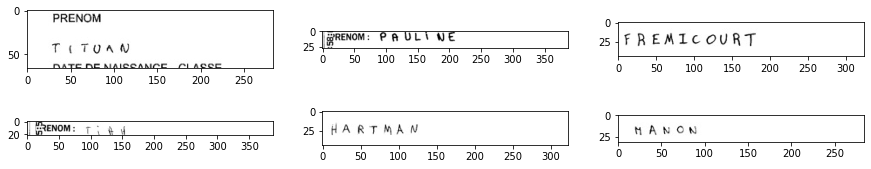

In [ ]:
#### Convert images into float and index them
unreadable_indexes = train_csv[train_csv['IDENTITY'] == 'UNREADABLE'].index

plt.figure(figsize = (15,3))

offset = 10
for i in range(6):
    ax = plt.subplot(2, 3, i+1)
    image_name = train_csv.iloc[unreadable_indexes[i + offset],0]
    image = cv2.imread(os.path.join(train_images_dir, image_name), cv2.IMREAD_GRAYSCALE)
    plt.imshow(image, 'gray')

In [ ]:
### Get the new dataframe
train_csv = train_csv[train_csv['IDENTITY'] != 'UNREADABLE']

validation_csv = validation_csv[validation_csv['IDENTITY'] != 'UNREADABLE']

test_csv = test_csv[test_csv['IDENTITY'] != 'UNREADABLE']

In [ ]:
### Display the new samples in the dataset
train_csv['IDENTITY'] = train_csv['IDENTITY'].str.lower()
validation_csv['IDENTITY'] = validation_csv['IDENTITY'].str.lower()
test_csv['IDENTITY'] = test_csv['IDENTITY'].str.lower()



characters = set(char for label in train_csv['IDENTITY'].values for char in label)

print("Number of samples found: ", len(train_csv.values))
print("Number of unique characters: ", len(characters))
print("Characters present: ", characters)

Number of samples found:  330294
Number of unique characters:  30
Characters present:  {'k', 'y', 'i', 'r', 'j', 'x', '`', 'c', "'", 'n', 'q', 'a', 'v', 'o', 'm', ' ', 't', '-', 'l', 'h', 'g', 'z', 'u', 'e', 'p', 's', 'w', 'd', 'f', 'b'}


In [ ]:
### Get the sequency in which images occur, sample pad and text
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

max_length = max([len(label) for label in train_csv['IDENTITY'].values])
tokenizer = Tokenizer(num_words = max_length, char_level = True)
tokenizer.fit_on_texts(train_csv['IDENTITY'].values)
word_index = tokenizer.word_index

sample_sequence = tokenizer.texts_to_sequences(['sample text'])
sample_pad = pad_sequences(sample_sequence, maxlen = max_length, padding = 'post')
sample_text = tokenizer.sequences_to_texts(sample_sequence)
print("Sample sequence: ", sample_sequence[0])
print("Sample pad: ", sample_pad[0])
print("Sample text: ", sample_text[0])

img_width = 50
img_height = 200

Sample sequence:  [10, 2, 11, 18, 5, 1, 25, 8, 1, 24, 8]
Sample pad:  [10  2 11 18  5  1 25  8  1 24  8  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0]
Sample text:  s a m p l e   t e x t


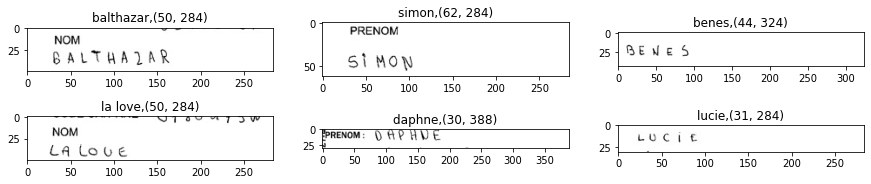

In [ ]:
### Show the the converted images in a subplots
plt.figure(figsize = (15,3))

offset = 0
for i in range(6):
    ax = plt.subplot(2, 3, i+1)
    image_name = train_csv.iloc[i + offset,0]
    image = cv2.imread(os.path.join(train_images_dir, image_name), cv2.IMREAD_GRAYSCALE)
    plt.imshow(image, 'gray')
    plt.title(f'{train_csv.iloc[i + offset,1]},{image.shape}')

In [ ]:
#### Process the sample images, each separately
images = train_csv['FILENAME'].values
labels = train_csv['IDENTITY'].values


def preprocess_single_sample(image_path, label, TEST = False):
    if TEST:
        img = cv2.imread(os.path.join(validation_images_dir, image_path), cv2.IMREAD_GRAYSCALE)
    else:
        img = cv2.imread(os.path.join(train_images_dir, image_path), cv2.IMREAD_GRAYSCALE)
        
    img = cv2.resize(img,(img_height, img_width), interpolation = cv2.INTER_AREA)
    img = cv2.rotate(img, cv2.ROTATE_90_CLOCKWISE) / 255
    
    label_sequence = tokenizer.texts_to_sequences([label])
    label = pad_sequences(label_sequence, maxlen = max_length, padding = 'post')[0]
    
    return img,label

In [ ]:
### Define the length of each dataset
train_length = 30000
validation_length = 3000
test_length = 3000

indices = np.arange(len(train_csv))
np.random.shuffle(indices)

test_indices = np.arange(len(test_csv))
np.random.shuffle(test_indices)

In [ ]:
### Create models and append each single image to the models
x_train = []
y_train = []
train_label_len = []
for i in range(train_length):
    image_name = train_csv.iloc[indices[i], 0]
    label = train_csv.iloc[indices[i], 1]
    train_label_len.append(len(label))
    
    img, label = preprocess_single_sample(image_name, label)
    img = np.expand_dims(img, axis = 2)
    x_train.append(img)
    y_train.append(label)
    
x_train = np.array(x_train)
y_train = np.array(y_train)
train_label_len = np.array(train_label_len)

In [ ]:
x_val = []
y_val = []
valid_label_len = []

for i in range(train_length, train_length+validation_length):
    image_name = train_csv.iloc[indices[i], 0]
    label = train_csv.iloc[indices[i], 1]
    valid_label_len.append(len(label))
    
    img, label = preprocess_single_sample(image_name, label)
    img = np.expand_dims(img, axis = 2)
    x_val.append(img)
    y_val.append(label)

x_val = np.array(x_val)
y_val = np.array(y_val)
valid_label_len = np.array(valid_label_len)

In [ ]:
x_test = []
y_test = []

for i in range(test_length):
    image_name = train_csv.iloc[test_indices[i], 0]
    label = train_csv.iloc[test_indices[i], 1]
    
    img, _ = preprocess_single_sample(image_name, label)
    img = np.expand_dims(img, axis = 2)
    x_test.append(img)
    y_test.append(label)

x_test = np.array(x_test)
y_test = np.array(y_test)

In [ ]:
x_train.shape, x_val.shape, y_train.shape, y_val.shape

((30000, 200, 50, 1), (3000, 200, 50, 1), (30000, 34), (3000, 34))

In [ ]:
train_input_len = np.ones([train_length, 1]) * 48
valid_input_len = np.ones([validation_length, 1]) * 48
valid_output = np.zeros([validation_length])

In [ ]:
from keras import backend as K
def ctc_loss(args):
    labels, y_pred, input_length, label_length = args
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)

In [ ]:
input_img = layers.Input(shape=(200, 50, 1), name="image")
labels = layers.Input(name="label", shape=(max_length,))
input_length = layers.Input(name='input_length', shape=(1,))
label_length = layers.Input(name='label_length', shape=(1,))

x = layers.Conv2D(
    32,
    (3, 3),
    activation="relu",
    kernel_initializer="he_normal",
    padding="same",
    name="Conv1",
)(input_img)
x = layers.MaxPooling2D((2, 2), name="pool1")(x)


x = layers.Conv2D(
    64,
    (3, 3),
    activation="relu",
    kernel_initializer="he_normal",
    padding="same",
    name="Conv2",
)(x)
x = layers.MaxPooling2D((2, 2), name="pool2")(x)

x = layers.Reshape(target_shape=(50,768), name="reshape")(x)
x = layers.Dense(64, activation="relu", name="dense1")(x)
x = layers.Dropout(0.2)(x)


x = layers.Bidirectional(layers.LSTM(256, return_sequences=True, dropout=0.25))(x)
x = layers.Bidirectional(layers.LSTM(256, return_sequences=True, dropout=0.25))(x)
y_pred = layers.Dense(
    len(characters) + 1, activation="softmax", name="output"
)(x)

loss_out = layers.Lambda(ctc_loss, output_shape=(1,), name='ctc')([labels, y_pred, input_length, label_length])
model = keras.models.Model(inputs=[input_img, labels, input_length, label_length], 
                           outputs=loss_out,
                           name="ocr_model_v1")

2022-10-27 10:16:13.259085: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [ ]:
### Optimize our models
opt = keras.optimizers.Adam()

model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer=opt)
model.summary()

Model: "ocr_model_v1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image (InputLayer)              [(None, 200, 50, 1)] 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 200, 50, 32)  320         image[0][0]                      
__________________________________________________________________________________________________
pool1 (MaxPooling2D)            (None, 100, 25, 32)  0           Conv1[0][0]                      
__________________________________________________________________________________________________
Conv2 (Conv2D)                  (None, 100, 25, 64)  18496       pool1[0][0]                      
_______________________________________________________________________________________

In [ ]:
### Create epochs to test the accuracy of the models
epochs = 50
early_stopping_patience = 10
early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=early_stopping_patience, restore_best_weights=True
)

history = model.fit(
    x = (x_train, y_train, train_input_len, train_label_len),
    y = np.zeros([train_length]),
    validation_data = ([x_val, y_val, valid_input_len, valid_label_len], np.zeros([validation_length]) ),
    epochs=epochs,
    batch_size = 128,
    callbacks=[early_stopping]
)

2022-10-27 10:16:17.211134: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/50
235/235 [==============================] - 557s 2s/step - loss: 21.7754 - val_loss: 20.2010
Epoch 2/50
235/235 [==============================] - 545s 2s/step - loss: 19.5137 - val_loss: 19.1793
Epoch 3/50
235/235 [==============================] - 536s 2s/step - loss: 18.6478 - val_loss: 17.5221
Epoch 4/50
235/235 [==============================] - 540s 2s/step - loss: 16.3944 - val_loss: 14.4708
Epoch 5/50
235/235 [==============================] - 538s 2s/step - loss: 13.3016 - val_loss: 11.0043
Epoch 6/50
235/235 [==============================] - 545s 2s/step - loss: 10.3334 - val_loss: 7.7517
Epoch 7/50
235/235 [==============================] - 541s 2s/step - loss: 8.2801 - val_loss: 6.5316
Epoch 8/50
235/235 [==============================] - 539s 2s/step - loss: 6.8999 - val_loss: 5.6376
Epoch 9/50
235/235 [==============================] - 535s 2s/step - loss: 6.1038 - val_loss: 4.7887
Epoch 10/50
235/235 [==============================] - 538s 2s/step - loss: 5.63

In [ ]:
#### Predict the models
prediction_model = keras.models.Model(
    model.get_layer(name="image").input, model.get_layer(name="output").output
)
prediction_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
image (InputLayer)           [(None, 200, 50, 1)]      0         
_________________________________________________________________
Conv1 (Conv2D)               (None, 200, 50, 32)       320       
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 100, 25, 32)       0         
_________________________________________________________________
Conv2 (Conv2D)               (None, 100, 25, 64)       18496     
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 50, 12, 64)        0         
_________________________________________________________________
reshape (Reshape)            (None, 50, 768)           0         
_________________________________________________________________
dense1 (Dense)               (None, 50, 64)            49216 

In [ ]:
### Decode the prediction models to return texts of the images
def decode_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0][
        :, :max_length
    ]
    output_text = []
    for res in results:
        decoded = tokenizer.sequences_to_texts([res.numpy()])
        output_text.append(decoded)
    return output_text

In [ ]:
### Compare the actual images and predictions
preds = prediction_model.predict(x_test)
pred_texts = decode_predictions(preds)

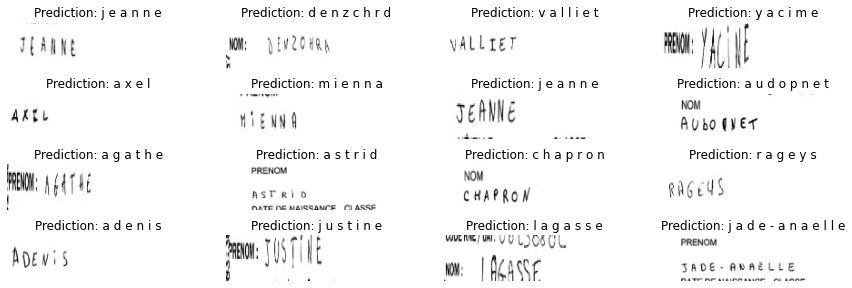

In [ ]:
### Display the texts of the images after decoding
_, ax = plt.subplots(4, 4, figsize=(15, 5))
for i in range(16):
    img = x_test[i]
    img = cv2.rotate(img, cv2.ROTATE_90_COUNTERCLOCKWISE)
    title = f"Prediction: {pred_texts[i][0]}"
    ax[i // 4, i % 4].imshow(img, cmap="gray")
    ax[i // 4, i % 4].set_title(title)
    ax[i // 4, i % 4].axis("off")
plt.show()